# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico III : Introducción al aprendizaje automático

**Antes de empezar:**
- [Instalar spaCy y el modelo de lenguaje con el que van a trabajar](https://spacy.io/models#quickstart)

**Consideraciones:**
- Se evalúa el estilo y prolijidad del código.
- Se permite hacer trabajo extra, siempre y cuando las actividades básicas estén resueltas.

**Recomendación:**
- Hay muchos ejemplos de código en internet, no se sientan obligados a implementar todo desde cero.

### Librerías

In [1]:
!pip3 install spotipy
!pip3 install pandas
!pip3 install spacy
!pip3 install pymusixmatch
!pip3 install nltk
!pip3 install sklearn
!pip3 install lyricsgenius

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

### Dependencias y acceso a APIs

In [2]:
import pandas as pd
import numpy as np
import spotipy
import spacy
from spotipy.oauth2 import SpotifyClientCredentials
from musixmatch import Musixmatch

import requests
import json
import lyricsgenius

client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

nlp = spacy.load("en_core_web_sm") # completar con el modelo que van a utilizar

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
musixmatch = Musixmatch('1aa5272f4402bf2f082ad2f3958c2c62') # se puede reemplazar por otra API si da mejores resultados

csv_folder_path = './TP_3_CSV_Files/{}'


In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [4]:
def parse_string_to_list(text):
    return text.strip("[]").replace("'","").split(", ")
    
df_song_base = pd.read_csv(csv_folder_path.format('songs_base_with_lyrics_sanitized_final.csv'),sep='#', 
                          converters={"genres": lambda x: parse_string_to_list(x),
                                      "artists": lambda x: parse_string_to_list(x),
                                     }
                         )
df_song_base.head()

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key'...","[art pop, dance pop, deconstructed club, elect...",0.0055
1,Anoche,1cwTMSQeMaA9fVKEF1iWeD,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.23, 'energy': 0.434, 'key':...","[art pop, dance pop, deconstructed club, elect...",0.3901
2,Sin Rumbo,0aL27vskbMpwsMGUkHm3Zf,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.289, 'energy': 0.28, 'key':...","[art pop, dance pop, deconstructed club, elect...",0.0000
3,La Gata Bajo la Lluvia,2kfSFdq2h0xLXq01em1zc7,[Rocío Dúrcal],['2uyweLa0mvPZH6eRzDddeB'],Sus 16 Grandes Exitos,1QXxmsxolhkqiFtI1mpX4i,"{'danceability': 0.499, 'energy': 0.648, 'key'...","[bolero, cancion melodica, grupera, latin, lat...",0.0057
4,Querida,5ySxlyvySBhIEvoO2xx7uT,[Juan Gabriel],['2MRBDr0crHWE5JwPceFncq'],Recuerdos II,1xrQ48Vvnvm3SmAbnIukGt,"{'danceability': 0.528, 'energy': 0.383, 'key'...","[cancion melodica, latin, latin pop]",0.0000


In [5]:
audio_features_dict = { 'song_id':[],
                        'danceability': [],
                       'energy': [],
                       'key': [],
                       'loudness': [],
                       'mode': [],
                       'speechiness': [],
                       'acousticness': [],
                       'instrumentalness': [],
                       'liveness': [],
                       'valence': [],
                       'tempo': []
                      }

for index, row in df_song_base.iterrows():
    dict_row = eval(row.audio_features)
    audio_features_dict.get('song_id').append(row.song_id)
    audio_features_dict.get('danceability').append(dict_row.get('danceability'))
    audio_features_dict.get('energy').append(dict_row.get('energy'))
    audio_features_dict.get('key').append(dict_row.get('key'))
    audio_features_dict.get('loudness').append(dict_row.get('loudness'))
    audio_features_dict.get('mode').append(dict_row.get('mode'))
    audio_features_dict.get('speechiness').append(dict_row.get('speechiness'))
    audio_features_dict.get('acousticness').append(dict_row.get('acousticness'))
    audio_features_dict.get('instrumentalness').append(dict_row.get('instrumentalness'))
    audio_features_dict.get('liveness').append(dict_row.get('liveness'))
    audio_features_dict.get('valence').append(dict_row.get('valence'))
    audio_features_dict.get('tempo').append(dict_row.get('tempo'))
df_audio_features = pd.DataFrame(audio_features_dict)
df_audio_features.head()

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7j9DYPyCuvSAtPcevpAkzb,0.161,0.482,1,-11.210,0,0.0472,0.486,0.40900,0.371,0.0926,161.092
1,1cwTMSQeMaA9fVKEF1iWeD,0.230,0.434,10,-12.402,0,0.0551,0.570,0.00000,0.115,0.0834,80.793
2,0aL27vskbMpwsMGUkHm3Zf,0.289,0.280,9,-15.335,1,0.0433,0.874,0.00443,0.124,0.0391,124.835
3,2kfSFdq2h0xLXq01em1zc7,0.499,0.648,7,-5.812,1,0.0331,0.723,0.00000,0.576,0.4640,88.140
4,5ySxlyvySBhIEvoO2xx7uT,0.528,0.383,2,-11.170,1,0.0258,0.376,0.00000,0.110,0.4600,89.089


In [6]:
df_full_original = pd.merge(df_song_base, df_audio_features, how='inner', on='song_id')
df_full_original.head()

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key'...","[art pop, dance pop, deconstructed club, elect...",0.0055,0.161,0.482,1,-11.210,0,0.0472,0.486,0.40900,0.371,0.0926,161.092
1,Anoche,1cwTMSQeMaA9fVKEF1iWeD,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.23, 'energy': 0.434, 'key':...","[art pop, dance pop, deconstructed club, elect...",0.3901,0.230,0.434,10,-12.402,0,0.0551,0.570,0.00000,0.115,0.0834,80.793
2,Sin Rumbo,0aL27vskbMpwsMGUkHm3Zf,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.289, 'energy': 0.28, 'key':...","[art pop, dance pop, deconstructed club, elect...",0.0000,0.289,0.280,9,-15.335,1,0.0433,0.874,0.00443,0.124,0.0391,124.835
3,La Gata Bajo la Lluvia,2kfSFdq2h0xLXq01em1zc7,[Rocío Dúrcal],['2uyweLa0mvPZH6eRzDddeB'],Sus 16 Grandes Exitos,1QXxmsxolhkqiFtI1mpX4i,"{'danceability': 0.499, 'energy': 0.648, 'key'...","[bolero, cancion melodica, grupera, latin, lat...",0.0057,0.499,0.648,7,-5.812,1,0.0331,0.723,0.00000,0.576,0.4640,88.140
4,Querida,5ySxlyvySBhIEvoO2xx7uT,[Juan Gabriel],['2MRBDr0crHWE5JwPceFncq'],Recuerdos II,1xrQ48Vvnvm3SmAbnIukGt,"{'danceability': 0.528, 'energy': 0.383, 'key'...","[cancion melodica, latin, latin pop]",0.0000,0.528,0.383,2,-11.170,1,0.0258,0.376,0.00000,0.110,0.4600,89.089


In [7]:
df_model = df_full_original.copy()
df_model['genres'] = df_model['genres'].apply(lambda x : x[0])
df_model["genres"] = df_model["genres"].astype('category')
df_model["genres_cat"] = df_model["genres"].cat.codes
for index, row in df_model.iterrows():
    if row.artists[0] == 'Rodrigo':
        df_model['genres'][index] = 'cuarteto'
df_model.head()

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres_cat
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key'...",art pop,0.0055,0.161,...,1,-11.210,0,0.0472,0.486,0.40900,0.371,0.0926,161.092,9
1,Anoche,1cwTMSQeMaA9fVKEF1iWeD,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.23, 'energy': 0.434, 'key':...",art pop,0.3901,0.230,...,10,-12.402,0,0.0551,0.570,0.00000,0.115,0.0834,80.793,9
2,Sin Rumbo,0aL27vskbMpwsMGUkHm3Zf,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.289, 'energy': 0.28, 'key':...",art pop,0.0000,0.289,...,9,-15.335,1,0.0433,0.874,0.00443,0.124,0.0391,124.835,9
3,La Gata Bajo la Lluvia,2kfSFdq2h0xLXq01em1zc7,[Rocío Dúrcal],['2uyweLa0mvPZH6eRzDddeB'],Sus 16 Grandes Exitos,1QXxmsxolhkqiFtI1mpX4i,"{'danceability': 0.499, 'energy': 0.648, 'key'...",bolero,0.0057,0.499,...,7,-5.812,1,0.0331,0.723,0.00000,0.576,0.4640,88.140,11
4,Querida,5ySxlyvySBhIEvoO2xx7uT,[Juan Gabriel],['2MRBDr0crHWE5JwPceFncq'],Recuerdos II,1xrQ48Vvnvm3SmAbnIukGt,"{'danceability': 0.528, 'energy': 0.383, 'key'...",cancion melodica,0.0000,0.528,...,2,-11.170,1,0.0258,0.376,0.00000,0.110,0.4600,89.089,12


### 1) Recopilar los datos obtenidos en los prácticos anteriores

Para esta parte consideraremos [la playlist colaborativa de la mentoría](https://open.spotify.com/playlist/2IuD0qZb14cji5y52crdsO?si=nfHRPDquQRyotEcXc4tG7Q), de esta obtendremos:
- Las features del audio de las canciones
- Las features textuales de sus letras

Además es necesario aplicar el mismo preprocesamiento que aplicamos en los prácticos anteriores para ambos tipos de features (el preprocesamiento del p1 a las features de audio y el de p2 al de features textuales) y obtener el género de cada canción, que en caso de ser más de uno para una canción el equipo deberá discutir una estrategia para estos casos y comentarla en el informe.

Luego, se separará al dataset resultante en **X** e **y**, donde:
- X es el conjunto de features
- y es la etiqueta, en este caso el género de la canción, que deberá ser codificado en valores del tipo **int**

Por último, se dividirá a estos dos conjuntos en los splits **train** y **test**

**Recomendaciones:**
- Obtener las features por separado y hacer un join de los datasets.
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)
- Si usan features categóricas, ENCODEARLAS!

In [8]:
from sklearn.model_selection import GridSearchCV, train_test_split

# Features

In [9]:
df_category = df_model[['genres','genres_cat']]
df_category = df_category.drop_duplicates(keep='first', ignore_index=True)
df_category

,genres,genres_cat
0,art pop,9
1,bolero,11
2,cancion melodica,12
3,argentine heavy metal,2
4,cantautor,13
5,argentine rock,8
6,cumbia chilena,18
7,grupera,28
8,argentine punk,6
9,celtic metal,14


In [10]:
data_frame = df_model[['danceability',
                       'energy','key','mode',
                       'speechiness','acousticness','instrumentalness',
                       'liveness','genres_cat']]

#['lyrics_sentiment','danceability',
#                       'energy','key','mode',
#                       'speechiness','acousticness','instrumentalness',
#                       'liveness','valence','tempo','genres_cat']
data_frame

,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,genres_cat
0,0.161,0.482,1,0,0.0472,0.486,0.409000,0.371,9
1,0.230,0.434,10,0,0.0551,0.570,0.000000,0.115,9
2,0.289,0.280,9,1,0.0433,0.874,0.004430,0.124,9
3,0.499,0.648,7,1,0.0331,0.723,0.000000,0.576,11
4,0.528,0.383,2,1,0.0258,0.376,0.000000,0.110,12
...,...,...,...,...,...,...,...,...,...
788,0.355,0.772,7,0,0.0438,0.276,0.000015,0.806,8
789,0.506,0.876,7,1,0.0459,0.106,0.000000,0.967,8
790,0.600,0.897,7,1,0.0470,0.157,0.000610,0.877,8
791,0.423,0.593,9,0,0.0393,0.696,0.000000,0.651,8


# Split Dataset

In [11]:


df_x = data_frame.drop(['genres_cat'], axis=1)
df_y = data_frame['genres_cat']
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
print('x_train: {} x_test: {} y_train: {}  y_test : {}'.format(len(x_train),len(x_test), len(y_train), len(y_test)))

x_train: 634 x_test: 159 y_train: 634  y_test : 159


In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=50)
print('x_train: {} x_valid: {} y_train: {}  y_valid : {}'.format(len(x_train),len(x_valid), len(y_train), len(y_valid)))

x_train: 507 x_valid: 127 y_train: 507  y_valid : 127


### 2) Elegir tres modelos de clasificadores multiclase

Aquí escogeremos tres modelos diferentes y luego compararemos su rendimiento para esta tarea. El procedimiento será el siguiente:
- Inicializar los modelos
- Entrenarlos usando el split **train** de los datos

**Recomendación:**
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)

In [13]:
import numpy as np

from sklearn import tree
from sklearn import datasets
from sklearn import model_selection

# Decision Trees

In [14]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

predictions = clf.predict(x_train)
print ('Train Accuracy: %d ' % ((np.sum(y_train == predictions))/float(y_train.size)*100))
predictions = clf.predict(x_valid)
print ('Valid Accuracy: %d ' % ((np.sum(y_valid == predictions))/float(y_valid.size)*100))

Train Accuracy: 100 
Valid Accuracy: 25 


In [15]:
clf_1 = tree.DecisionTreeRegressor(max_depth=100, criterion="mse")
clf_1 = clf_1.fit(x_train, y_train)

predictions = clf_1.predict(x_train)
print ('Train Accuracy: %d ' % ((np.sum(y_train == predictions))/float(y_train.size)*100))

predictions = clf_1.predict(x_valid)
print ('Valid Accuracy: %d ' % ((np.sum(y_valid == predictions))/float(y_valid.size)*100))

Train Accuracy: 100 
Valid Accuracy: 29 


# MLP

In [16]:
model_params = {
    'beta_1': (0.8, 0.9),
    'beta_2': (0.99999, 0.999),
}
model = MLPClassifier(random_state=42,
                      verbose=True,
                      max_iter=1000,
                      alpha=0.03,
                      n_iter_no_change=30,
                      hidden_layer_sizes=(96,))

search = GridSearchCV(model,
                      model_params,
                      cv=3,
                      n_jobs=-1,  # Use all processors.
                      scoring='accuracy',
                      verbose=1)  # scoring='balanced_accuracy'

search.fit(x_train, y_train)

best_found_clf = search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Data Science\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    8.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.9s finished


Iteration 1, loss = 3.50879024
Iteration 2, loss = 3.30752281
Iteration 3, loss = 3.12481976
Iteration 4, loss = 2.96468896
Iteration 5, loss = 2.83531843
Iteration 6, loss = 2.72509449
Iteration 7, loss = 2.63815558
Iteration 8, loss = 2.57011259
Iteration 9, loss = 2.51786276
Iteration 10, loss = 2.47946994
Iteration 11, loss = 2.45398787
Iteration 12, loss = 2.43439086
Iteration 13, loss = 2.41844529
Iteration 14, loss = 2.40694673
Iteration 15, loss = 2.39504999
Iteration 16, loss = 2.38400457
Iteration 17, loss = 2.37148395
Iteration 18, loss = 2.35975675
Iteration 19, loss = 2.34976166
Iteration 20, loss = 2.33880289
Iteration 21, loss = 2.32826283
Iteration 22, loss = 2.31780036
Iteration 23, loss = 2.30728413
Iteration 24, loss = 2.29723923
Iteration 25, loss = 2.28767155
Iteration 26, loss = 2.27759733
Iteration 27, loss = 2.26797513
Iteration 28, loss = 2.25795214
Iteration 29, loss = 2.24939309
Iteration 30, loss = 2.24063509
Iteration 31, loss = 2.23324905
Iteration 32, los

Iteration 269, loss = 1.72941010
Iteration 270, loss = 1.72821484
Iteration 271, loss = 1.72798334
Iteration 272, loss = 1.72761682
Iteration 273, loss = 1.72577988
Iteration 274, loss = 1.72542063
Iteration 275, loss = 1.72435721
Iteration 276, loss = 1.72380169
Iteration 277, loss = 1.72205033
Iteration 278, loss = 1.72117386
Iteration 279, loss = 1.72089648
Iteration 280, loss = 1.71934134
Iteration 281, loss = 1.71882623
Iteration 282, loss = 1.71800154
Iteration 283, loss = 1.71730543
Iteration 284, loss = 1.71581651
Iteration 285, loss = 1.71630203
Iteration 286, loss = 1.71479139
Iteration 287, loss = 1.71350674
Iteration 288, loss = 1.71260137
Iteration 289, loss = 1.71235908
Iteration 290, loss = 1.71124886
Iteration 291, loss = 1.70979509
Iteration 292, loss = 1.70951858
Iteration 293, loss = 1.70906809
Iteration 294, loss = 1.70885690
Iteration 295, loss = 1.70696824
Iteration 296, loss = 1.70611805
Iteration 297, loss = 1.70532642
Iteration 298, loss = 1.70457465
Iteration 

Iteration 544, loss = 1.55908135
Iteration 545, loss = 1.55957596
Iteration 546, loss = 1.55939808
Iteration 547, loss = 1.55890636
Iteration 548, loss = 1.55858348
Iteration 549, loss = 1.55725066
Iteration 550, loss = 1.55777808
Iteration 551, loss = 1.55751856
Iteration 552, loss = 1.55696414
Iteration 553, loss = 1.55666336
Iteration 554, loss = 1.55727647
Iteration 555, loss = 1.55511512
Iteration 556, loss = 1.55549953
Iteration 557, loss = 1.55608498
Iteration 558, loss = 1.55542772
Iteration 559, loss = 1.55378068
Iteration 560, loss = 1.55265395
Iteration 561, loss = 1.55270826
Iteration 562, loss = 1.55299480
Iteration 563, loss = 1.55204671
Iteration 564, loss = 1.55206754
Iteration 565, loss = 1.55108838
Iteration 566, loss = 1.55031108
Iteration 567, loss = 1.55080618
Iteration 568, loss = 1.54984503
Iteration 569, loss = 1.54907190
Iteration 570, loss = 1.54884851
Iteration 571, loss = 1.54855059
Iteration 572, loss = 1.54814841
Iteration 573, loss = 1.54807304
Iteration 

Iteration 812, loss = 1.46557170
Iteration 813, loss = 1.46362573
Iteration 814, loss = 1.46401279
Iteration 815, loss = 1.46324245
Iteration 816, loss = 1.46318537
Iteration 817, loss = 1.46274269
Iteration 818, loss = 1.46480564
Iteration 819, loss = 1.46195224
Iteration 820, loss = 1.46070972
Iteration 821, loss = 1.46123502
Iteration 822, loss = 1.46328536
Iteration 823, loss = 1.46149848
Iteration 824, loss = 1.46095166
Iteration 825, loss = 1.46050340
Iteration 826, loss = 1.46026422
Iteration 827, loss = 1.45958067
Iteration 828, loss = 1.46021460
Iteration 829, loss = 1.45960095
Iteration 830, loss = 1.45836217
Iteration 831, loss = 1.45997533
Iteration 832, loss = 1.45861386
Iteration 833, loss = 1.45782057
Iteration 834, loss = 1.45727235
Iteration 835, loss = 1.45738274
Iteration 836, loss = 1.45650668
Iteration 837, loss = 1.45614512
Iteration 838, loss = 1.45595544
Iteration 839, loss = 1.45579847
Iteration 840, loss = 1.45623848
Iteration 841, loss = 1.45500322
Iteration 

C:\Users\Data Science\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


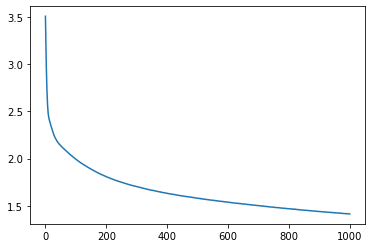

In [17]:
plt.plot(best_found_clf.loss_curve_);

In [18]:
# results dataframe is used to store the computed results
results = pd.DataFrame(columns=('clf', 'best_acc'))
results = results.append(
    {'clf': best_found_clf, 'best_acc': search.best_score_},
    ignore_index=True
)
results

,clf,best_acc
0,"MLPClassifier(alpha=0.03, beta_2=0.99999, hidd...",0.353057


### 3) Informe: Comparar el rendimiento de los modelos

Una vez entrenados los tres modelos, compararemos su rendimiento:
- Correr los modelos usando el split **test**
- Obtener el reporte de clasificación y la matriz de confusión para cada modelo
- Graficar llevando a 2 dimensiones nuestro split **test** pintando con colores diferentes según la etiqueta correspondiente.
- Graficar de manera similar los resultados obtenidos con cada clasificador y sobre esto la función de clasificación obtenida.
- Guardar los modelos usando **pickle**
- Discutir los resultados obtenidos

**Recomendación:**
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)

### 4) Tareas adicionales:

Estas tareas servirán para extrapolar un poco el trabajo básico, y también sumarán puntos extra. Deben elegir una o más de las siguientes:
-  Análisis sobre el balance de clases del dataset, balanceo usando **subsampling** u **oversampling** y comparación de resultados vs el modelo básico
- Optimización de hiperparámetros y comparación de resultados vs el modelo básico
- Graficar importancia de features
- Graficar correlación de features

**Recomendación:**
- Hacer varias ahora puede ahorrarles tiempo en el futuro